## Global Settings

In [1]:
from collections import defaultdict
import os
import shutil
import cv2
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [8]:
root_directory = os.path.join(os.getcwd()) # '/Users/Username/dataset'
images_directory = os.path.join(root_directory, "images")
masks_directory = os.path.join(root_directory, "annotations", "trimaps")

# Dir_name 
# [GREY]Grey Scale - rgb2gray
# [SILO]실루엣 - 고양이 흰색 그외 검정색
# [TXTR]텍스쳐 - 바운딩 박스 크롭하고 그 중 Half
# [BACK]배경 - 고양이 검정색 배경 그대로

aug_dir_names = ['grey', 'silo', 'txtr', 'back']
for name in aug_dir_names:
    dir_name = os.path.join(root_directory, f'images_{name}')
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)

In [9]:
images_filenames = list(sorted(os.listdir(images_directory)))
correct_images_filenames = [i for i in images_filenames if cv2.imread(os.path.join(images_directory, i)) is not None]
correct_images_filenames = [i for i in correct_images_filenames if os.path.splitext(i)[1] == '.jpg']

## SILO

In [78]:
def preprocess_mask_silo(mask):
    mask = mask.astype(np.uint8)
    mask[(mask == 2.0) | (mask == 3.0)] = 0.0
    mask[mask == 1.0] = 255
    return mask

In [81]:
def to_silo(images_filenames, images_directory, target_directory):
    for i, image_filename in enumerate(images_filenames):
        extension = os.path.splitext(image_filename)[1] # find extension to exclue '.mat'
        if (extension == '.jpg'):
            image = cv2.imread(os.path.join(images_directory, image_filename))
            mask = cv2.imread(os.path.join(masks_directory, image_filename.replace(".jpg", ".png")), cv2.IMREAD_UNCHANGED,)
            silouetted = preprocess_mask_silo(mask)    
            cv2.imwrite(os.path.join(target_directory , image_filename), silouetted)     

In [ ]:
to_silo(correct_images_filenames, images_directory, os.path.join(root_directory, "images_silo"))

In [ ]:
# mask == 1.0: 고양이 부분
# mask == 2.0: 배경 부분
# mask == 3.0: 테두리 부분

## BACK

In [132]:
def preprocess_mask_back(mask):
    mask = mask.astype(np.uint8)
    mask[mask == 2.0] = 255
    mask[(mask == 1.0) | (mask == 3.0)] = 0
    return mask

In [133]:
def to_back(images_filenames, images_directory, target_directory):
    for i, image_filename in enumerate(images_filenames):
        extension = os.path.splitext(image_filename)[1] # find extension to exclue '.mat'
        if (extension == '.jpg'):
            image = cv2.imread(os.path.join(images_directory, image_filename))
            mask = cv2.imread(os.path.join(masks_directory, image_filename.replace(".jpg", ".png")), cv2.IMREAD_UNCHANGED,)
            mask = preprocess_mask_back(mask)  
            background_only = cv2.bitwise_and(image, image, mask = mask)
            cv2.imwrite(os.path.join(target_directory , image_filename), background_only)

In [134]:
to_back(correct_images_filenames, images_directory, os.path.join(root_directory, "images_back"))

## GREY

In [145]:
def to_grey(images_filenames, images_directory, target_directory):
    for i, image_filename in enumerate(images_filenames):
        extension = os.path.splitext(image_filename)[1] # find extension to exclue '.mat'
        if (extension == '.jpg'):
            image = cv2.imread(os.path.join(images_directory, image_filename))
            grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            cv2.imwrite(os.path.join(target_directory , image_filename), grey_image)

In [146]:
to_grey(correct_images_filenames, images_directory, os.path.join(root_directory, "images_grey"))

## TXTR(IMPLEMENTING..)

In [69]:
# mask == 1.0: 고양이 부분
# mask == 2.0: 배경 부분
# mask == 3.0: 테두리 부분
def preprocess_mask_txtr(mask):
    mask = mask.astype(np.uint8)
    mask[(mask == 2.0) | (mask == 3.0)] = 0.0
    mask[mask == 1.0] = 255
    # print(mask)

    # rect = cv.minAreaRect(cnt)
    return mask

In [240]:
def to_txtr(images_filenames, images_directory, target_directory):
    for i, image_filename in enumerate(images_filenames):
        extension = os.path.splitext(image_filename)[1] # find extension to exclue '.mat'
        if (extension == '.jpg'):
            image = cv2.imread(os.path.join(images_directory, image_filename))
            mask = cv2.imread(os.path.join(masks_directory, image_filename.replace(".jpg", ".png")), cv2.IMREAD_UNCHANGED,)
        
        _,thresh = cv2.threshold(mask,1,255,0)
        contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE) # contours: (1, 4, 1, 2)
        bbs = []
        for contour in contours:
            # print(contour)
            bb = cv2.boundingRect(contour)
            bbs.append(bb)
            # print('foo:',bb)

        print(len(bbs))
        if len(bbs) > 1:
            x,y,w,h = bbs[-2]
            print(x,y,w,h)
            print(w>50)
            if not w > 50 or h > 50:
                x,y,w,h = bbs[-1]
                x += int(w/4)
                y += int(h/4)
                w = int(w/2)
                h = int(h/2)

        else:
            x,y,w,h = bbs[-1]

        print(x,y,w,h)
        txtred_image = image[y + int(h/4): y + int(3*h/4), x + int(w/4): x + int(3*w/4)]
        cv2.imwrite(os.path.join(target_directory , image_filename), txtred_image)


In [241]:
to_txtr(correct_images_filenames, images_directory, os.path.join(root_directory, "images_txtr"))

2
106 80 339 249
True
150 100 300 200
1
0 0 375 500
2
64 85 261 391
True
98 125 197 250
3
66 50 241 86
True
112 78 225 156
1
0 0 500 465
2
38 74 346 261
True
125 87 250 175
2
53 64 510 233
True
150 90 300 181
3
244 110 214 252
True
125 93 250 187
2
200 192 1067 717
True
384 256 768 512
1
0 0 500 448
1
0 0 500 404
2
64 299 50 70
False
70 112 141 225
2
44 65 127 157
True
48 72 96 144
1
0 0 400 319
2
69 100 343 240
True
125 100 250 201
1
0 0 490 500
3
20 110 376 297
True
160 106 320 212
2
225 77 174 336
True
160 105 320 211
2
376 72 3 3
False
125 91 250 183
1
0 0 333 500
3
203 111 3 3
False
125 100 250 200
1
0 0 333 500
2
255 224 3 3
False
75 74 150 148
6
119 103 113 325
True
83 125 167 250
4
73 95 128 270
True
66 100 133 200
1
0 0 242 233
2
20 21 254 236
True
75 69 150 139
2
159 89 316 179
True
125 83 250 166
2
100 108 222 387
True
83 125 166 250
2
224 35 216 305
True
125 89 250 179
2
94 94 318 293
True
125 105 250 211
2
66 230 127 97
True
66 100 133 200
2
62 33 349 283
True
125 93 250 1

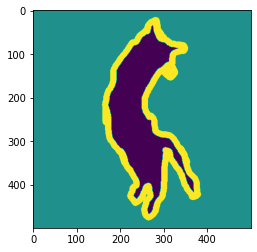

In [187]:
mask = to_txtr(correct_images_filenames, images_directory, os.path.join(root_directory, "images_txtr"))
plt.imshow(mask)

foo: (172, 34, 198, 434)
foo: (0, 0, 500, 500)
172 34 198 434


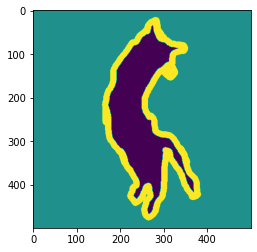

In [188]:
ret,thresh = cv2.threshold(mask,1,255,0)
# plt.imshow(thresh)
contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE) # contours: (1, 4, 1, 2)
bbs = []
for contour in contours:
    # print(contour)
    bb = cv2.boundingRect(contour)
    bbs.append(bb)
    print('foo:',bb)

len(bbs)
if len(bbs) > 1:
    x,y,w,h = bbs[-2]
else:
    x,y,w,h = bbs[0]
print(x, y, w, h)
plt.imshow(mask)

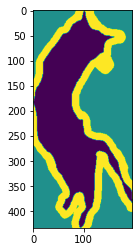

In [189]:
cropped_img = mask[y: y + h, x: x + w]
plt.imshow(cropped_img)

In [190]:
y + int(h/4)

142

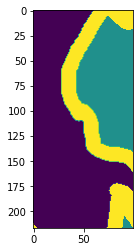

In [191]:
cropped_img = mask[y + int(h/4): y + int(3*h/4), x + int(w/4): x + int(3*w/4)]
plt.imshow(cropped_img)

In [96]:
thresh

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [98]:
x, y, w, h = cv2.boundingRect(thresh)
print(x, y, w, h)

0 0 600 473


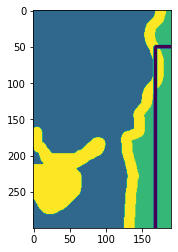

In [73]:
plt.clf()
ret, img_thresholded = cv2.threshold(mask, 1, 3, 0)
contours, _ = cv2.findContours(img_thresholded, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE) 
xs = []
ys = []
ws = []
hs = []
x, y, w, h = cv2.boundingRect(cnt)
cv2.rectangle(mask, (x, y), (x+w, y+h), (0, 255, 255), 3)
plt.imshow(mask)
# for c in contours:
#     x, y, w, h = cv2.boundingRect(cnt)
#     # print(x, y, w, h)
#     xs.append(x)
#     ys.append(y)
#     ws.append(w)
#     hs.append(h)
#     # cv2.rectangle(mask, (x, y), (x+w, y+h), (0, 255, 255), 3)
#     # plt.imshow(mask)

In [61]:
xs

[]

In [62]:
ys

[]

In [63]:
ws

[]

In [64]:
hs

[]

In [48]:
plt.clf()
ret, img_thresholded = cv2.threshold(mask, 1, 3, 0)
contours, _ = cv2.findContours(img_thresholded, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
# cnt = contours[4]

# for c in contours: 

x, y, w, h = cv2.boundingRect(cnt)
print(x, y, w, h)
cv2.rectangle(mask, (x, y), (x+w, y+h), (0, 255, 255), 3)
plt.imshow(mask)

IndexError: list index out of range

296 363 1 1
280 300 1 36
287 275 6 66
228 275 65 85
172 250 52 110
280 54 13 218
230 54 47 11
206 54 21 11
172 54 55 167
164 46 137 322
4 4 394 377


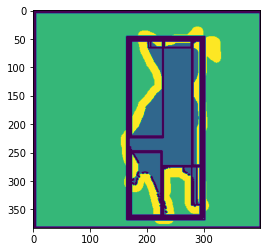

In [20]:
plt.clf()
ret, img_thresholded = cv2.threshold(mask, 1, 2, 0)
contours, hier = cv2.findContours(img_thresholded, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
for c in contours:
    # xy, wh, r = cv2.minAreaRect(c) # ((299.5, 199.5), (399.0, 599.0), 90.0)
    # rect = cv2.minAreaRect(c)
    # box = cv2.boxPoints(rect)
    # print(box)
    # x, y = xy
    # w, h = wh
    # print(x, y, w, h, r)

    x,y,w,h = cv2.boundingRect(c)
    print(x, y, w, h)
    cv2.rectangle(mask,(x,y),(x+w,y+h),(0,255,0),2)

plt.imshow(mask)
plt.show()


In [21]:
contours[5]

array([[[287,  54]],

       [[287,  55]],

       [[285,  57]],

       [[284,  57]],

       [[282,  59]],

       [[282,  66]],

       [[283,  66]],

       [[284,  67]],

       [[285,  67]],

       [[289,  71]],

       [[289,  72]],

       [[290,  73]],

       [[290, 110]],

       [[289, 111]],

       [[289, 114]],

       [[288, 115]],

       [[288, 117]],

       [[287, 118]],

       [[287, 120]],

       [[285, 122]],

       [[285, 123]],

       [[284, 124]],

       [[284, 125]],

       [[282, 127]],

       [[282, 129]],

       [[281, 130]],

       [[281, 132]],

       [[280, 133]],

       [[280, 148]],

       [[281, 149]],

       [[281, 151]],

       [[284, 154]],

       [[284, 155]],

       [[285, 156]],

       [[285, 158]],

       [[288, 161]],

       [[288, 163]],

       [[289, 164]],

       [[289, 177]],

       [[290, 178]],

       [[290, 186]],

       [[291, 187]],

       [[291, 191]],

       [[290, 192]],

       [[290, 200]],

       [[2

In [22]:
cv2.boundingRect(contours[5])

(280, 54, 13, 218)

In [125]:
mask.shape

(400, 600)

In [126]:
len(mask[200])

600

In [127]:
mask[200]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

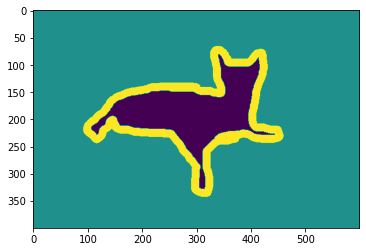

In [128]:
plt.imshow(mask)
plt.show()

In [129]:
ret, img_thresholded = cv2.threshold(mask, 1, 2, 0)

In [130]:
contours, hier = cv2.findContours(img_thresholded, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

In [131]:
for c in contours:
    print(c)
    area = cv2.contourArea(c)
    print(area)

[[[339  81]]

 [[340  80]]

 [[341  80]]

 [[346  85]]

 [[346  86]]

 [[347  87]]

 [[347  88]]

 [[349  90]]

 [[349  92]]

 [[350  93]]

 [[350  95]]

 [[351  96]]

 [[351  98]]

 [[354 101]]

 [[355 101]]

 [[356 102]]

 [[358 102]]

 [[359 103]]

 [[395 103]]

 [[396 102]]

 [[398 102]]

 [[400 100]]

 [[401 100]]

 [[409  92]]

 [[409  91]]

 [[411  89]]

 [[411  88]]

 [[413  86]]

 [[414  87]]

 [[414  91]]

 [[415  92]]

 [[415  98]]

 [[416  99]]

 [[416 108]]

 [[415 109]]

 [[415 111]]

 [[414 112]]

 [[414 118]]

 [[413 119]]

 [[413 120]]

 [[412 121]]

 [[412 123]]

 [[411 124]]

 [[411 125]]

 [[410 126]]

 [[410 127]]

 [[409 128]]

 [[409 130]]

 [[408 131]]

 [[408 132]]

 [[407 133]]

 [[407 134]]

 [[406 135]]

 [[406 137]]

 [[405 138]]

 [[405 142]]

 [[404 143]]

 [[404 144]]

 [[403 145]]

 [[403 147]]

 [[402 148]]

 [[402 157]]

 [[401 158]]

 [[401 163]]

 [[400 164]]

 [[400 169]]

 [[399 170]]

 [[399 172]]

 [[398 173]]

 [[398 179]]

 [[397 180]]

 [[397

299.5 199.5 399.0 599.0


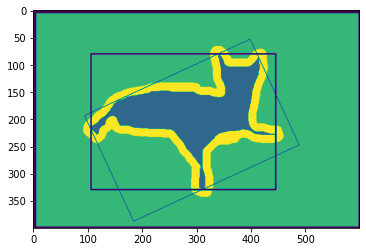

In [143]:
for c in contours:
    # x, y, w, h = cv2.boundingRect(c)
    # print(x, y, w, h)
    # foo = cv2.rectangle(mask, (x, y), (x+w,y+h), (0, 255, 0), 2)

    xy, wh, _ = cv2.minAreaRect(c) # ((299.5, 199.5), (399.0, 599.0), 90.0)
    x, y = xy
    w, h = wh
    print(x, y, w, h)
    
    # box = cv2.boxPoints(rect)
    # convert all coordinates floating point values to int
    # box = np.int0(box)
    # draw a red 'nghien' rectangle
    # cv2.drawContours(foo, [box], 0, (0, 0, 255))

    # print(foo)
    plt.imshow(foo)
    plt.show()


In [136]:
foo

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [18]:
ret,thresh1 = cv2.threshold(mask,127,255,cv2.THRESH_BINARY)
ret

127.0

In [23]:
thresh1[[165]]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [13]:
x, y, w, h = cv2.boundingRect(mask)

In [16]:
w

600

In [17]:
h

400

In [151]:
silouetted

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)